In [1]:
# Standard DS & plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import preprocess_text, compute_coherence, plot_coefficients, prepare_data, compile_model
# NLP librarie
import gensim.corpora as corpora
from nltk.probability import FreqDist
from textblob import TextBlob
from wordcloud import WordCloud

from gensim.models import wrappers
import pyLDAvis.gensim

# Classic ML 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline 

# Deep learning 
from keras.callbacks import LearningRateScheduler

# Serialization
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
positive = pd.read_csv('data/positive.tsv', sep='\t', index_col=0)
positive['target'] = 1
negative = pd.read_csv('data/negative.tsv', sep='\t', index_col=0)
negative['target'] = 0

## Checking null values

In [3]:
positive.isnull().sum()

Title          0
Abstract    2016
target         0
dtype: int64

In [4]:
negative.isnull().sum()

Title       0
Abstract    0
target      0
dtype: int64

A lot of positive articles contain only Title. Therefore we'll need to concatenate Title & Abstract together to analyze them together.

In [5]:
data_raw = positive.append(negative)

In [6]:
data_raw['concat'] = data_raw.Title.map(str) + " " + data_raw.Abstract.fillna(' ').map(str)

In [7]:
# data = preprocess_text(data_raw)

In [8]:
# shortcut for preprocessing
import ast

data = pd.read_csv('./data/clean_joined.csv')
data['lemmatized'] = data['lemmatized'].apply(ast.literal_eval)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['lemma_str'], data['target'], test_size=0.1)

# 1. Text length

In [44]:
data_raw['counts_title'] = data_raw['Title'].str.split().apply(len)
data_raw['counts_abstract'] = data_raw['Abstract'].fillna('').str.split().apply(len)
data_raw['counts'] = data_raw['concat'].fillna('').str.split().apply(len)
data_raw['tokens'] = data_raw['concat'].str.len()

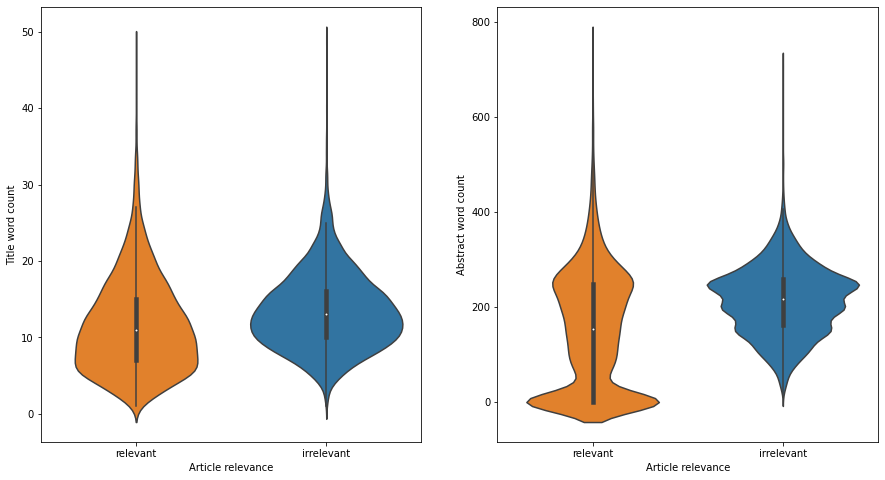

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.violinplot(x='target', y='counts_title', data=data_raw, ax=ax[0])
ax[0].set(ylabel="Title word count", xlabel="Article relevance", xticklabels=['irrelevant', 'relevant'])
ax[0].invert_xaxis()
sns.violinplot(x='target', y='counts_abstract', data=data_raw, ax=ax[1])
ax[1].set(ylabel="Abstract word count", xlabel="Article relevance", xticklabels=['irrelevant', 'relevant'])
ax[1].invert_xaxis()

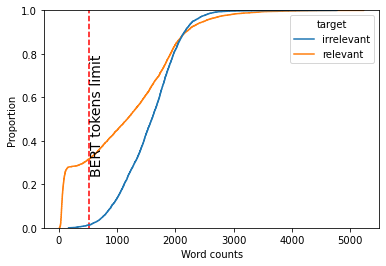

In [46]:
g = sns.ecdfplot(x='tokens', hue='target', data=data_raw)
line = g.vlines(512, 0, 1, color='r', linestyle='--', label='BERT tokens limit')
g.set(xlabel="Word counts")
new_labels = ['irrelevant', 'relevant']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.text(530,0.25,'BERT tokens limit', rotation=90, fontsize=14);

Apart from `NA` values in positive abstracts, Titles and Abstracts of irrelevant articles are longer. Because of high percent of missing data in Abstracts of positive articles further analysis concentrates on concatenated text.

# 2. Text data preprocessing

## Sentiment analysis

In [4]:
data['sentiment'] = data['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)

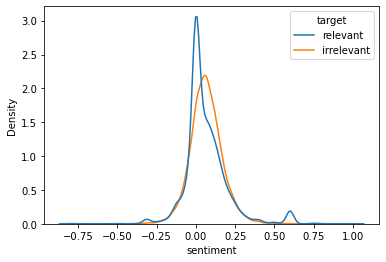

In [5]:
g = sns.kdeplot(x='sentiment', hue='target', hue_order = [1, 0], data=data)
new_labels = ['relevant', 'irrelevant']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l);

Obviously, there are not much sentiment indicating words used in scientific articles, but we see an outlier in the positive group, lets see this abstract

In [6]:
data['sentiment'].sort_values()

12870   -0.800000
1286    -0.800000
9937    -0.800000
2056    -0.800000
1362    -0.714286
           ...   
62       0.750000
5588     0.750000
808      0.800000
262      0.800000
4883     1.000000
Name: sentiment, Length: 14203, dtype: float64

In [7]:
data.loc[data['sentiment'] >= 0.8, 'concat'].values

array(['Accidental iron poisoning in childhood. Six cases including one fatality Between 1962 and 1973, six children were admitted to the Massachusetts General Hospital because of accidental iron poisoning. Intoxication was life-threatening in two children whose serum iron concentrations exceeded their iron binding capacities. One of these patients died despite intensive supportive care and desferoxamine therapy. Although iron poisoning appears to be relatively uncommon, it can produce life-threatening and fatal intoxication in children.',
       'Hepatitis in patients receiving intraarterial chemotherapy for metastatic colorectal carcinoma Fifty-one patients with metastatic colorectal carcinoma confined to the liver received intraarterial chemotherapy through the hepatic artery via a subcutaneous pump. The chemotherapy consisted of sequential 14-day infusions of floxuridine (FUDR) and dichloromethotrexate (DCMTX) or a 14-day infusion of FUDR and bolus mitomycin (MMC). Twenty-four pati

Positive sentiments contain words such as **best** or **succesful**. 

In [8]:
data.loc[data['sentiment'] <= -0.8, 'concat'].values

array(['Colchicine intoxication. A reappraisal of its pathology based on a study of three fatal cases  ',
       'Liver disorders in patients receiving chlorpromazine or isoniazid Based on information derived from computers and clinical records obtained from general practitioners in the United Kingdom, we estimated the frequency of liver toxicity associated with two known hepatotoxins, chlorpromazine and isoniazid. Among the cohort of 10,502 users of chlorpromazine, 14 had illnesses compatible with drug-induced liver disease, a frequency of 1.3/1000 users (95% Cl 0.8, 2.2). Four presumed cases of the disorder occurred among 921 users of isoniazid, for a frequency of 4/1000 users (95% Cl 1.7, 11.1). This study provides population-based quantification of the frequency of liver disorders associated with the use of these two agents.',
       "Binding interaction of gatifloxacin with bovine serum albumin The binding of gatifloxacin to bovine serum albumin (BSA) in aqueous solution was studi

Negative sentiments contain words such as **fatal** or **malignant**.

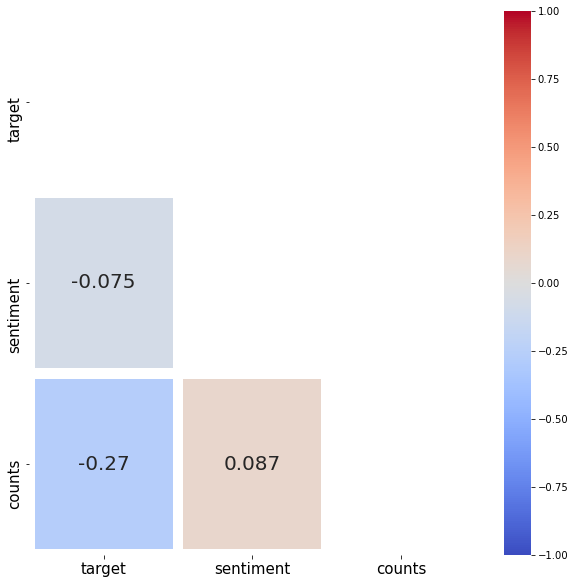

In [9]:
correlation = data[['target','sentiment', 'counts']].corr(method='spearman')
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 20}, linewidths=10, vmin=-1, vmax=1, mask=mask);

Counts are inversely correlates with target - as a lot of positive articles are shorter because of lack of the abstract (2016 entries).

## Word clouds

In [35]:
words_pos = data.loc[data['target'] == 1, 'lemmatized']
allwords_pos = []
for wordlist in words_pos:
    allwords_pos += wordlist
    
words_neg = data.loc[data['target'] == 0, 'lemmatized']
allwords_neg = []
for wordlist in words_neg:
    allwords_neg += wordlist

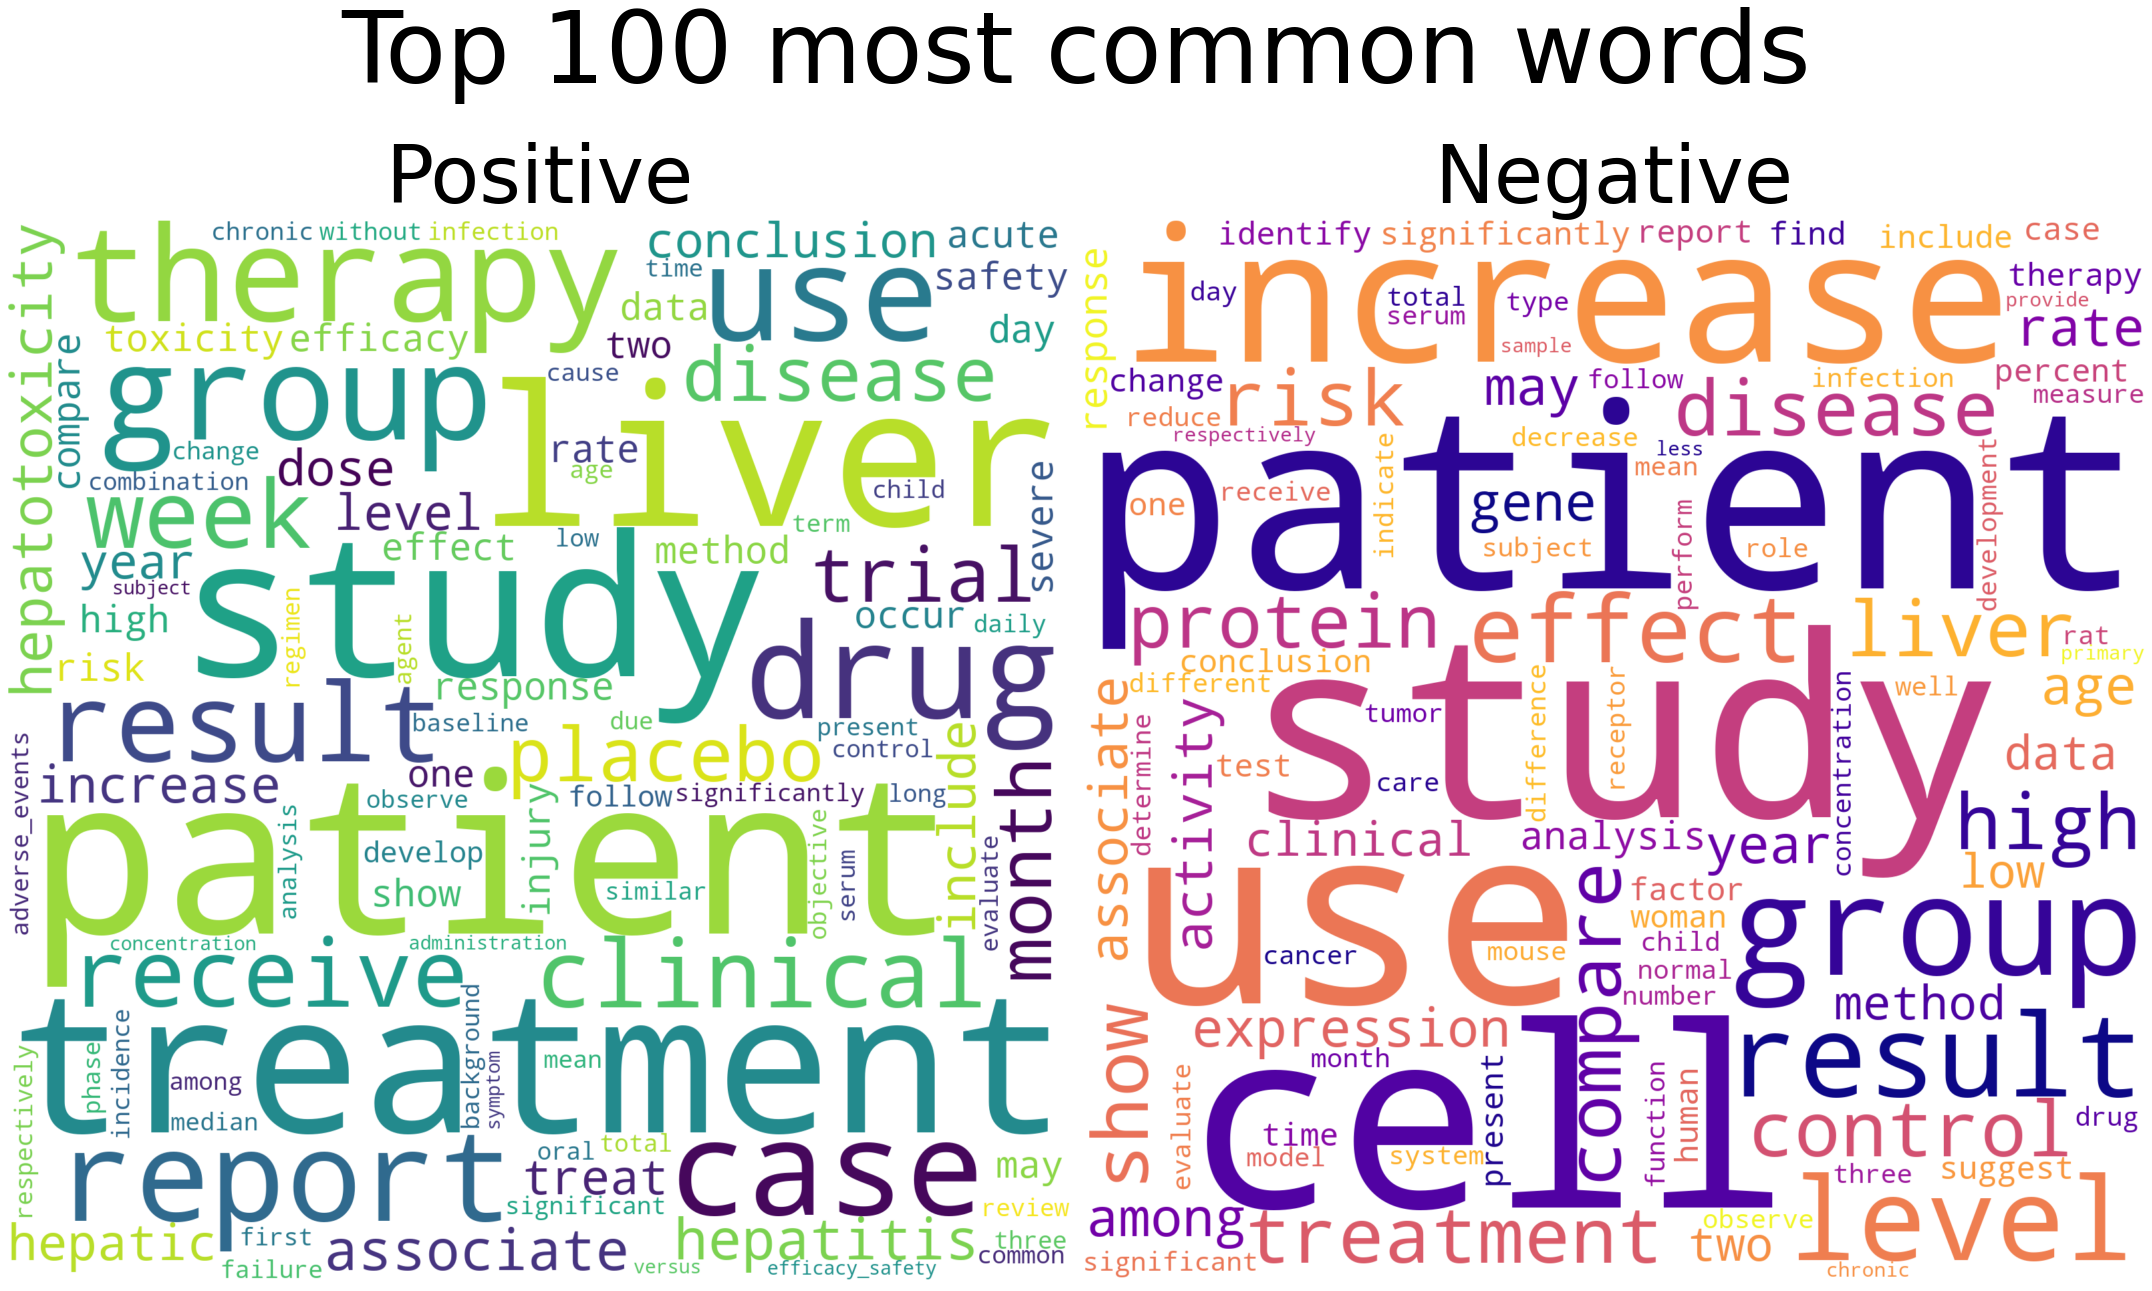

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(30,20), facecolor='white')

mostcommon_pos = FreqDist(allwords_pos).most_common(100)
wordcloud_pos = WordCloud(width=1600, height=1600, 
                          background_color='white').generate(str(' '.join(w for w, n in mostcommon_pos)))
ax[0].imshow(wordcloud_pos, interpolation="bilinear")
ax[0].axis('off')
ax[0].set_title('Positive', fontsize=80)

mostcommon_neg = FreqDist(allwords_neg).most_common(100)
wordcloud_neg = WordCloud(width=1600, height=1600, 
                          background_color='white', colormap='plasma').generate(str(' '.join(w for w, n in mostcommon_neg)))
ax[1].imshow(wordcloud_neg, interpolation="bilinear")
ax[1].axis('off')
ax[1].set_title('Negative', fontsize=80)
fig.suptitle('Top 100 most common words', fontsize=100)
fig.tight_layout();

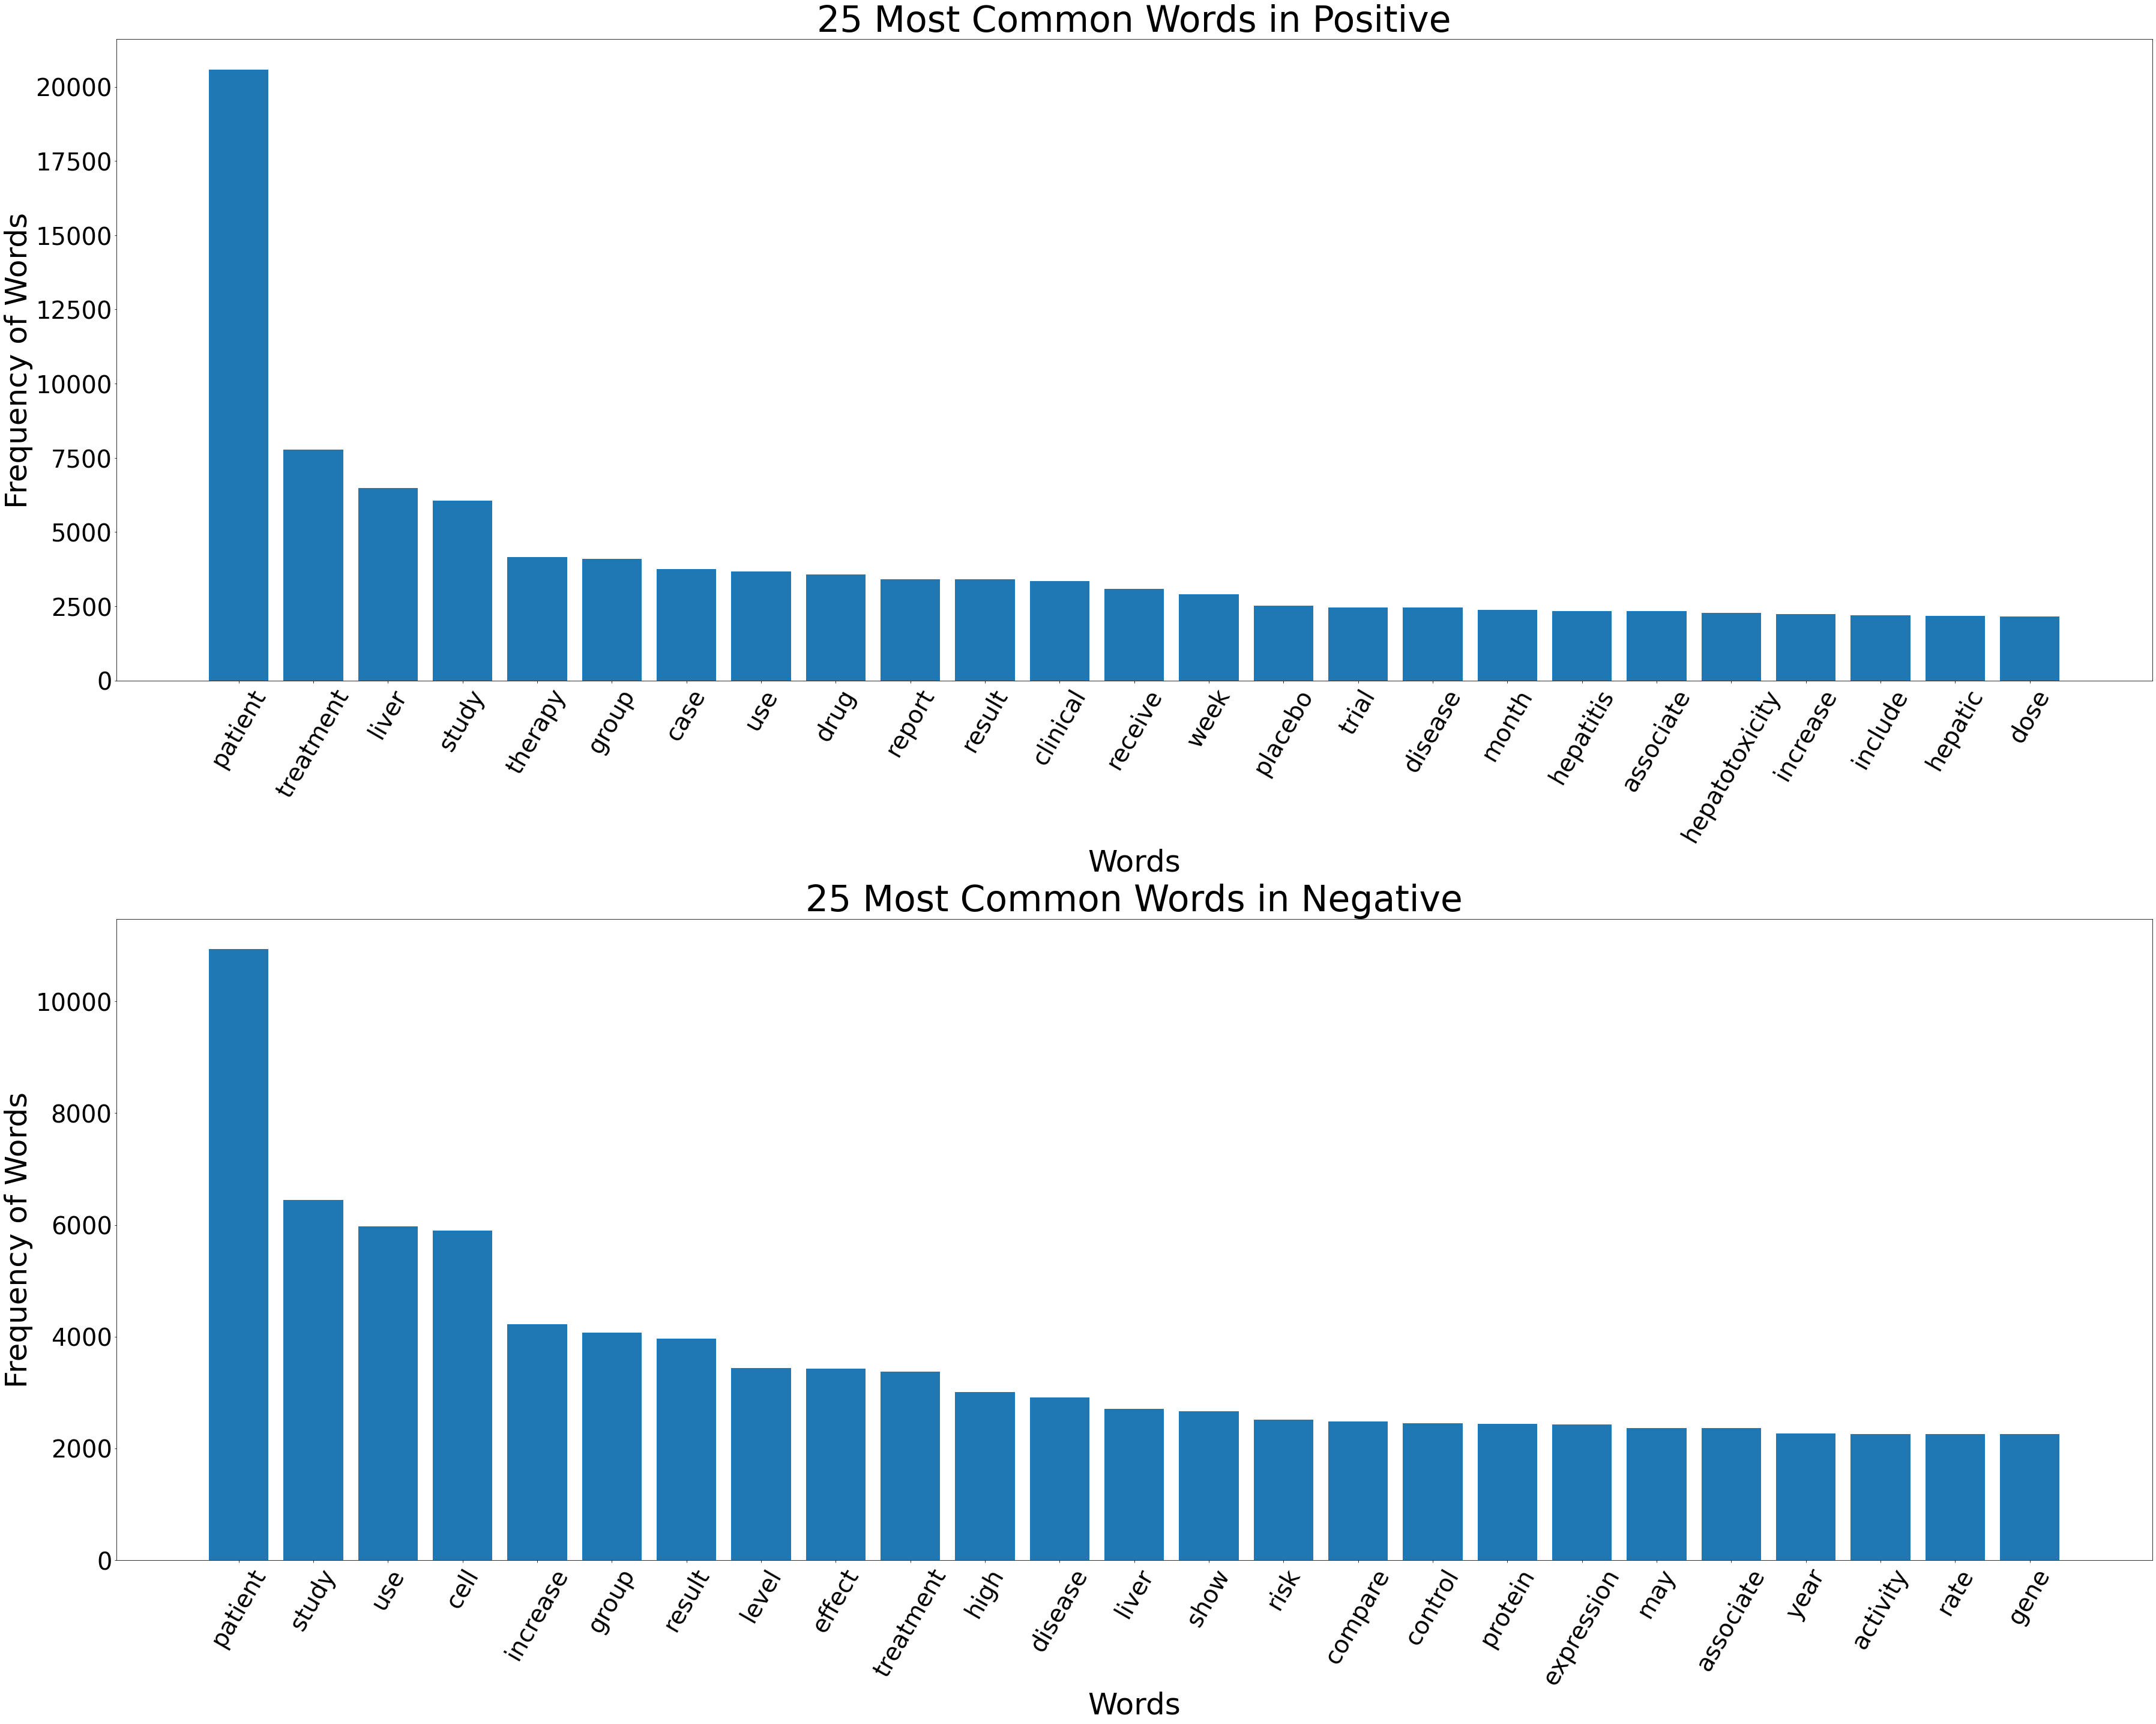

In [38]:
mostcommon_small_pos = FreqDist(allwords_pos).most_common(25)
x, y = zip(*mostcommon_small_pos)
mostcommon_small_neg = FreqDist(allwords_neg).most_common(25)
x_n, y_n = zip(*mostcommon_small_neg)
fig, ax = plt.subplots(2, 1, figsize=(50,40))
ax[0].bar(x, y)
ax[0].set_xlabel('Words', fontsize=50)
ax[0].set_ylabel('Frequency of Words', fontsize=50)
ax[0].tick_params(axis='x', rotation=60, labelsize=40)
ax[0].tick_params(axis='y', labelsize=40)
ax[0].set_title('25 Most Common Words in Positive', fontsize=60)

ax[1].bar(x_n, y_n)
ax[1].set_xlabel('Words', fontsize=50)
ax[1].set_ylabel('Frequency of Words', fontsize=50)
ax[1].tick_params(axis='x', rotation=60, labelsize=40)
ax[1].tick_params(axis='y', labelsize=40)
ax[1].set_title('25 Most Common Words in Negative', fontsize=60)
fig.tight_layout();

This is what called "patient-oriented medicine". There are a lot of common words in the most frequent ones, therefore Bag-of-words may be an inefficient strategy, but we will still try it as a baseline model. Embeddings would probably outpreform NBoW.

## Topic Modeling

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data['lemmatized'])

# Create Corpus
texts = data['lemmatized'].values

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [15]:
# Validating different LDA models
model_list, coherence_values = compute_coherence(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

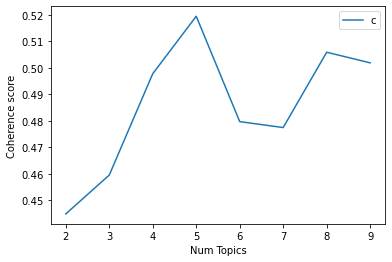

In [16]:
# Finding best number of topics
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
for n, v in optimal_model.print_topics(num_words=10):
    print(f'Topic {n+1}')
    print(v + '\n')

Topic 1
0.014*"risk" + 0.012*"study" + 0.010*"age" + 0.010*"year" + 0.009*"data" + 0.008*"woman" + 0.007*"percent" + 0.006*"associate" + 0.006*"child" + 0.006*"high"

Topic 2
0.069*"patient" + 0.029*"treatment" + 0.019*"group" + 0.017*"study" + 0.013*"receive" + 0.011*"week" + 0.011*"therapy" + 0.010*"trial" + 0.009*"month" + 0.009*"placebo"

Topic 3
0.023*"cell" + 0.009*"protein" + 0.009*"expression" + 0.008*"gene" + 0.007*"human" + 0.007*"activity" + 0.006*"show" + 0.005*"role" + 0.005*"suggest" + 0.005*"receptor"

Topic 4
0.018*"level" + 0.016*"increase" + 0.016*"effect" + 0.010*"control" + 0.009*"study" + 0.009*"change" + 0.008*"concentration" + 0.008*"subject" + 0.008*"decrease" + 0.007*"significantly"

Topic 5
0.033*"patient" + 0.030*"liver" + 0.020*"case" + 0.018*"drug" + 0.017*"report" + 0.011*"hepatitis" + 0.010*"hepatic" + 0.010*"disease" + 0.010*"clinical" + 0.010*"associate"



In [26]:
# Visualize the topics
lda_model = wrappers.ldamallet.malletmodel2ldamodel(model_list[3])
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'topic_modelling.html')

/home/wbezshapkin/.conda/envs/dili/lib/python3.6/site-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/home/wbezshapkin/.conda/envs/dili/lib/python3.6/site-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/home/wbezshapkin/.conda/envs/dili/lib/python3.6/site-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


# Classification

# 1. Classic ML

## 1.1. SVM (scikit-learn)

In [52]:
pipe_svm = Pipeline([('vect', TfidfVectorizer()), ('clf', SGDClassifier())])

In [ ]:
param_grid = {
              'vect__analyzer': ['word', 'char'],
              'vect__smooth_idf': [True, False],
              'vect__max_features': [5000, 10000, 15000, 20000, 25000, 30000],
              'vect__norm': ['l1', 'l2'],  
              'clf__alpha': np.logspace(-5, 3, 9),
              'clf__penalty': ['l1', 'l2', 'elasticnet'],
              'clf__max_iter': np.linspace(10, 200, 20)} 

grid = RandomizedSearchCV(pipe_svm, param_grid, n_iter=1000, cv=10,
                          n_jobs=20, random_state=42, refit=True, verbose=1)
  
# fitting the model for grid search
# grid.fit(X_train, y_train)

In [55]:
best_svm = grid.best_estimator_

In [56]:
best_svm

Pipeline(steps=[('vect', TfidfVectorizer(max_features=25000)),
                ('clf', SGDClassifier(max_iter=180.0))])

In [57]:
best_svm.score(X_test, y_test)

0.9394792399718508

94% accuracy with SVM only.  Considering that our dataset was balanced, this is not bad. I decided to use SGD implementation, because it improves training times drastically, which is important for our dataset.  
Let's see what features are responsible for text classification. 

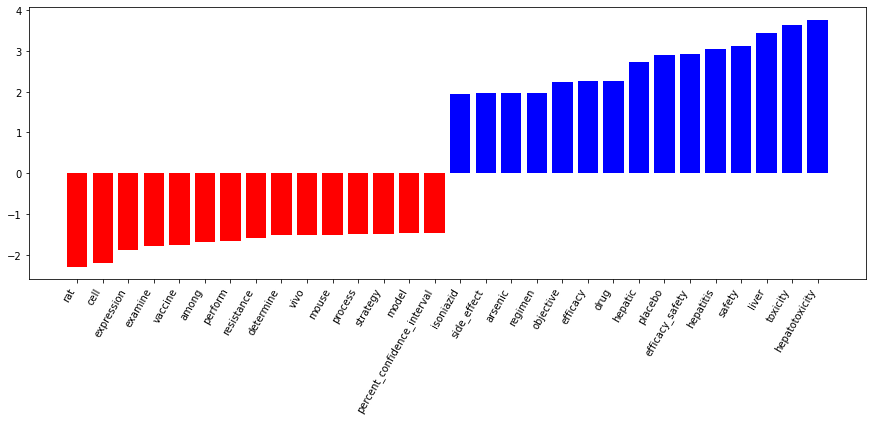

In [171]:
plot_coefficients(best_svm.named_steps['clf'], best_svm.named_steps['vect'].get_feature_names())

## 1.2. Naive Bayes (scikit-learn)

In [162]:
pipe_nb = Pipeline([('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

In [163]:
param_grid = {
              'vect__analyzer': ['word', 'char'],
              'vect__smooth_idf': [True, False],
              'vect__max_features': [5000, 10000, 15000, 20000, 25000, 30000],
              'vect__norm': ['l1', 'l2'],
              'clf__alpha': np.logspace(-5, 2, 8)}
grid = RandomizedSearchCV(pipe_nb, param_grid, n_iter=200, cv=10, 
                          random_state=42, refit=True, verbose=1)
  
# fitting the model for grid search
# grid.fit(X_train, y_train)

In [ ]:
best_nb = grid.best_estimator_

In [165]:
best_nb

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=30000, norm='l1',
                                 smooth_idf=False)),
                ('clf', MultinomialNB(alpha=0.01))])

In [166]:
best_nb.score(X_test, y_test)

0.944405348346235

94.5% accuracy on Multinomial Naive Bayes, that's a better result. We will stack both models for a final classificator. 

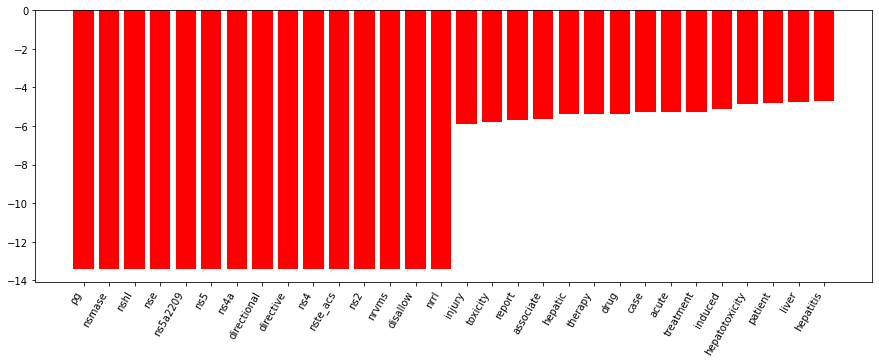

In [169]:
plot_coefficients(best_nb.named_steps['clf'], best_nb.named_steps['vect'].get_feature_names())

So, we are more interested in "human acute drug hepatotoxicity" than "mouse gene expression"

## 1.3. Stacked Classifier

In [70]:
estimators = [
     ('svc', best_svm),
     ('nb', best_nb)
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [173]:
clf.fit(X_train, y_train).score(X_test, y_test)

0.9542575650950035

Our stacked classifier reaches 95.5% accuracy, which is decent already. 

In [175]:
with open('./models/stacked-svm-nb.pkl', 'wb') as f:
    pickle.dump(clf, f)

# 2. Deep Learning

## 2.1. Neural bag of Words (NBOW) - Keras

In [10]:
# Preprocess sentences using Tokenizer
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
_, x_test = prepare_data(x_tr, X_test, model_type='nbow')
x_tr, x_val = prepare_data(x_tr, x_val, model_type='nbow')

In [11]:
nbow = compile_model(x_tr.shape[1], learning_rate=0.0005, model_type='nbow')

In [19]:
nbow.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                1280016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,280,161
Trainable params: 1,280,161
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Including learning rate decay - so to prevent overfitting
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [21]:
_epochs = 30
_batch_size = 32

history = nbow.fit(x_tr, y_tr, epochs=_epochs, verbose=0, batch_size=_batch_size,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

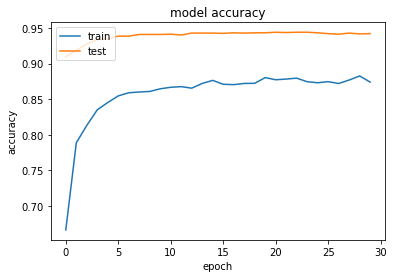

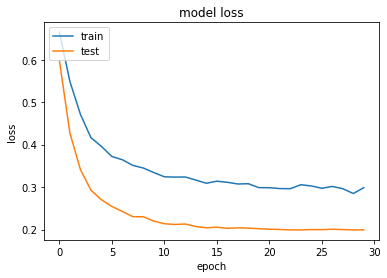

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [24]:
nbow.evaluate(x_test, y_test, batch_size=32)

45/45 [==============================] - 0s 3ms/step - loss: 0.1905 - accuracy: 0.9479


[0.1904653161764145, 0.947924017906189]

94.8% accuracy. Not great, not terrible. Probably ensembling could improve this score.

In [26]:
nbow.save('./models/nbow.h5')

## 2.2. LSTM text classification

In [27]:
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
_, x_test = prepare_data(x_tr, X_test, model_type='lstm')
x_tr, x_val = prepare_data(x_tr, x_val, model_type='lstm')

In [28]:
lstm = compile_model(x_tr.shape[1], learning_rate=5e-5, model_type='lstm')

In [29]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 128)          10240000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 10,371,713
Trainable params: 10,371,713
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Including learning rate decay - so to prevent overfitting
reduce_lr = LearningRateScheduler(lambda x: 5e-5 * 0.9 ** x)

In [31]:
_epochs = 5
_batch_size = 32

history = lstm.fit(x_tr, y_tr, epochs=_epochs, verbose=1, batch_size=_batch_size,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

Epoch 1/5
320/320 [==============================] - 209s 654ms/step - loss: 0.5603 - accuracy: 0.6913 - val_loss: 0.2807 - val_accuracy: 0.8971 - lr: 5.0000e-05
Epoch 2/5
320/320 [==============================] - 209s 654ms/step - loss: 0.2284 - accuracy: 0.9217 - val_loss: 0.2059 - val_accuracy: 0.9269 - lr: 4.5000e-05
Epoch 3/5
320/320 [==============================] - 210s 656ms/step - loss: 0.1702 - accuracy: 0.9446 - val_loss: 0.1885 - val_accuracy: 0.9304 - lr: 4.0500e-05
Epoch 4/5
320/320 [==============================] - 209s 654ms/step - loss: 0.1402 - accuracy: 0.9555 - val_loss: 0.1675 - val_accuracy: 0.9386 - lr: 3.6450e-05
Epoch 5/5
320/320 [==============================] - 210s 656ms/step - loss: 0.1165 - accuracy: 0.9646 - val_loss: 0.1610 - val_accuracy: 0.9425 - lr: 3.2805e-05


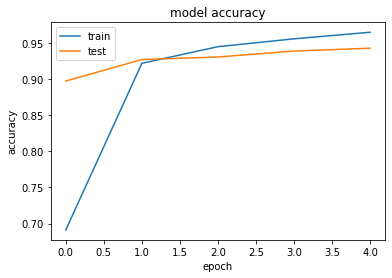

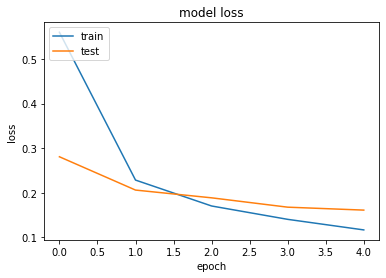

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [33]:
lstm.evaluate(x_test, y_test, batch_size=64)

23/23 [==============================] - 1s 52ms/step - loss: 0.1688 - accuracy: 0.9437


[0.1687563806772232, 0.9437016248703003]

94% and long training times, oh no, that won't work.

In [34]:
lstm.save('./models/lstm.h5')

## 2.3. BERT

In [9]:
import torch
import torch.nn as nn

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

There are 2 GPU(s) available.
Device name: GeForce RTX 2080 Ti


In [10]:
data['bert'] = data['concat'].apply(lambda x: x.lower())

In [11]:
# Create the BertClassfier class
from transformers import AutoModel

class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [12]:
from transformers import AutoTokenizer

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(strings):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for article in strings:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_article = tokenizer.encode_plus(
            text=article,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                 # Max length to truncate/pad
            truncation=True,
            padding="max_length",                   # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_article.get('input_ids'))
        attention_masks.append(encoded_article.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.bert, data.target, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [17]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=1)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size, num_workers=1)

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [20]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [21]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

test_labels = torch.tensor(y_test.values)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=8)

Tokenizing data...


In [22]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=8)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, epochs=4)

torch.save(bert_classifier, './models/scibert-trained.pkl', pickle_module=pickle)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.452231   |     -      |     -     |   7.35   
   1    |   40    |   0.329816   |     -      |     -     |   6.80   
   1    |   60    |   0.237446   |     -      |     -     |   6.82   
   1    |   80    |   0.260435   |     -      |     -     |   6.84   
   1    |   100   |   0.086887   |     -      |     -     |   6.83   
   1    |   120   |   0.414000   |     -      |     -     |   6.86   


KeyboardInterrupt: 

In [46]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

In [49]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.9704433497536946

In [53]:
len(probs[:, 1])

1421